# This notebook shows some functions to transform and plot the `tgviz` data, as well as how to project your personal genotypes into this space.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import umap

from cyvcf2 import VCF, Writer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def vcf2df(vcf_fname):
    """Convert a subsetted vcf file to pandas DataFrame
    and return sample-level population data"""
    samples = 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
    dfsamples = pd.read_csv(samples, sep='\t')
    dfsamples.set_index('sample', inplace=True)
    dfsamples.drop(columns=['Unnamed: 4', 'Unnamed: 5'], inplace=True)

    vcf_file = VCF(vcf_fname)
    df = pd.DataFrame(index=vcf_file.samples)
    for variant in vcf_file():
        df[variant.ID] = variant.gt_types

    df = df.join(dfsamples, how='outer')
    df = df.drop(columns=['pop', 'super_pop', 'gender'])

    return df, dfsamples

Explore the 55 AISNPs from the Kidd manuscript.

In [3]:
vcf_fname = '../data/Kidd.55AISNP.1kG.vcf'
df, dfsamples = vcf2df(vcf_fname)

In [4]:
# How many samples and AISNPs?
print(df.shape)

# Are the two DataFrames the same length?
print(df.shape[0] == dfsamples.shape[0])

(2504, 55)
True


`df` has sample accessions along the index and each SNP is represented in a column. 

In [5]:
df.head()

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
HG00096,0,1,0,3,0,0,0,1,0,3,...,0,0,1,0,0,3,3,1,1,0
HG00097,0,3,0,3,0,0,0,0,0,3,...,1,0,3,0,0,3,1,0,0,1
HG00099,0,1,0,1,3,1,0,3,0,3,...,0,0,1,0,0,1,1,0,0,1
HG00100,0,3,0,3,0,0,0,3,1,3,...,1,0,3,1,0,3,3,0,0,0
HG00101,0,1,0,3,1,1,0,3,3,3,...,0,0,3,0,0,3,3,1,0,1


In [6]:
dfsamples.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


One-hot encode the DataFrame

In [7]:
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)

Now, reduce the dimensionality of the DataFrame.

In [8]:
def reduce_dim(X, algorithm='PCA', n_components=4):
    """Reduce the dimensionality of the 55 AISNPs
    :param X: One-hot encoded 1kG 55 AISNPs.
    :type X: array
    :param algorithm: The type of dimensionality reduction to perform. 
        One of {PCA, UMAP, TSNE}
    :type algorithm: str 
    :param n_components: The number of components to return in X_red 
    :type n_components: int
    
    :returns: The transformed X[m, n] array, reduced to X[m, n_components] by algorithm.
    """
    
    if algorithm == 'PCA':
        X_red = PCA(n_components=n_components).fit_transform(X)
    elif algorithm == 'TSNE':
        # TSNE, Barnes-Hut have dim <= 3
        if n_components > 3:
            print('The Barnes-Hut method requires the dimensionaility to be <= 3')
            return None
        else:
            X_red = TSNE(n_components=n_components, n_jobs=4).fit_transform(X)
    elif algorithm == 'UMAP':
        X_red = umap.UMAP(n_components=n_components).fit_transform(X)
    else:
        return None
    return X_red

In [9]:
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

In [10]:
X_emb

array([[-1.55299653, -1.86735236, -0.79348409],
       [-1.73080784, -1.8835127 , -0.41352836],
       [-1.9727361 , -2.06077771, -0.24033429],
       ...,
       [-0.76779494, -0.14213626,  0.56403244],
       [-0.69352985, -0.71180019,  0.3913898 ],
       [-1.43860498,  0.13584696,  0.37935029]])

In [11]:
def encode_class(pop_level='pop'):
    """Encode the population lables for plotting."""
    le = LabelEncoder()
    if pop_level == 'pop':
        labels = le.fit_transform(dfsamples['pop'].values)
    elif pop_level == 'super_pop':
        labels = le.fit_transform(dfsamples['super_pop'].values)
    else:
        return None
    return le, labels

In [12]:
# pop_level can be either 'pop' or 'super_pop'
le, labels = encode_class(pop_level='super_pop')

In [23]:
def plot_samples(X_emb, x_component=None, y_component=None):
    """"""
    unique = np.unique(labels)
    colors = [plt.cm.tab10_r(i/float(len(unique)-1)) for i in range(len(unique))]
    assignments = [colors[i] for i in labels]

    plt.figure(figsize=(10,10));
    for (i,cla) in enumerate(set(labels)):
        s = None
        if le.inverse_transform([cla])[0] == 'me':
            s=500
        xc = [p for (j,p) in enumerate(X_emb[:, x_component-1]) if labels[j]==cla]
        yc = [p for (j,p) in enumerate(X_emb[:, y_component-1]) if labels[j]==cla]
        cols = [c for (j,c) in enumerate(assignments) if labels[j]==cla]
        plt.scatter(xc, yc, s=s, c=cols, label=le.inverse_transform([cla])[0])
    plt.legend();
    plt.xlabel('Component {}'.format(x_component));
    plt.ylabel('Component {}'.format(y_component));
    plt.title('Projection of 1000 Genomes Samples\ninto Lower Dimensional Space\nUsing 55 AIMs from Kidd et al.');
    plt.savefig('/Users/kevin/projects/tgviz/me_vs_1kgp.png')

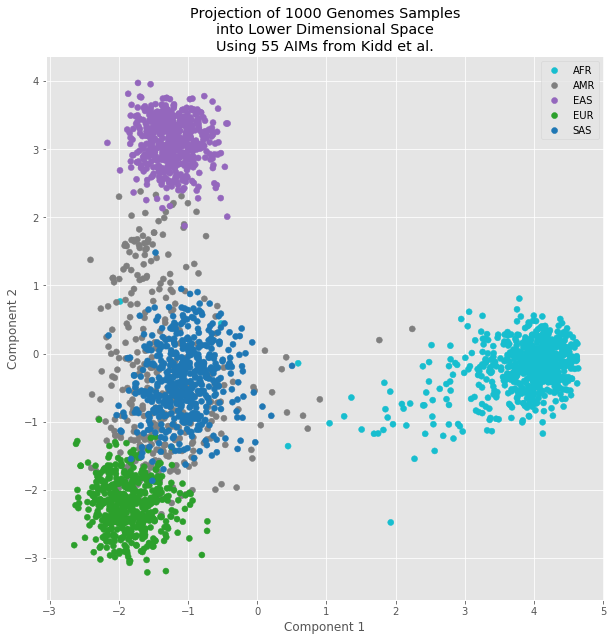

In [14]:
plot_samples(X_emb, x_component=1, y_component=2)

# Investigate your own personal vcf file -- converted from 23andMe

In [15]:
df.head(3)

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
HG00096,0,1,0,3,0,0,0,1,0,3,...,0,0,1,0,0,3,3,1,1,0
HG00097,0,3,0,3,0,0,0,0,0,3,...,1,0,3,0,0,3,1,0,0,1
HG00099,0,1,0,1,3,1,0,3,0,3,...,0,0,1,0,0,1,1,0,0,1


### add an additional record for myself

In [16]:
# start with UNKNOWN genotypes == 2 in cyvcf
df.loc['me'] = np.repeat([2], 55)

In [17]:
df.tail(3)

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
NA21143,0,3,0,1,0,0,0,3,1,3,...,0,0,0,0,0,3,3,0,3,0
NA21144,0,1,0,3,0,3,0,3,3,3,...,0,0,3,0,1,3,3,0,0,1
me,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


## Similarly, add myself to dfsamples

In [18]:
dfsamples.loc['me'] = ['me', 'me', 'male']

In [19]:
dfsamples.tail()

,pop,super_pop,gender
sample,,,
NA21141,GIH,SAS,female
NA21142,GIH,SAS,female
NA21143,GIH,SAS,female
NA21144,GIH,SAS,female
me,me,me,male


## Read the AISNPs from the raw file

In [20]:
dfaim = pd.read_csv('../data/Kidd_55_AISNPs.txt', sep='\t')
# iterate over the AISNPs
dfaim.head()

,dbSNP rs#,Chr,Build 37 nt position,73-population Fst
0,rs3737576,1,"101,709,563",0.44
1,rs7554936,1,"151,122,489",0.39
2,rs2814778,1,"159,174,683",0.82
3,rs798443,2,"7,968,275",0.34
4,rs1876482,2,"17,362,568",0.75


## Intersect my genotypes with AISNPs

In [21]:
# must be bgzipped and tabix indexed
myvcf = VCF('/Users/kevin/data/77687130/member.77687130.uniq.vcf.gz')

for i, row in dfaim.iterrows():
    chrom = row['Chr']
    pos = row['Build 37 nt position'].replace(',', '')
    rsid = row['dbSNP rs#']
    for variant in myvcf(f'{chrom}:{pos}-{pos}'):
        df.loc['me', variant.ID] = variant.gt_types[0]            

In [22]:
df.loc['me'].head()

rs3737576    0
rs7554936    2
rs2814778    0
rs798443     1
rs1876482    0
Name: me, dtype: int64

# Now rerun the pipeline

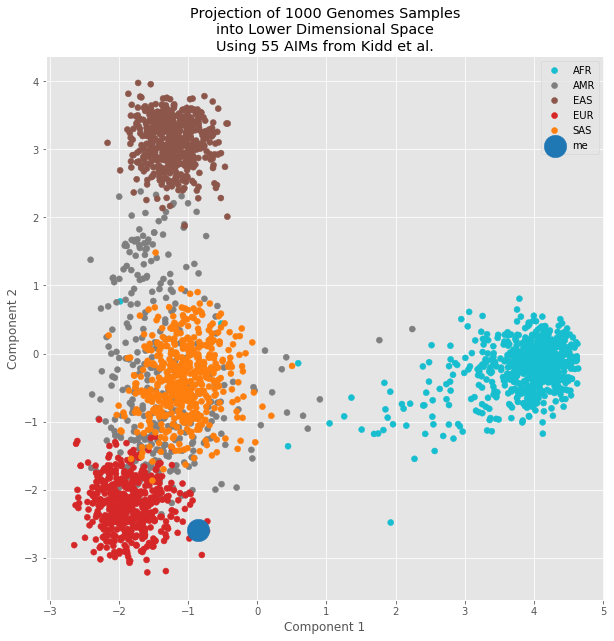

In [24]:
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

le, labels = encode_class(pop_level='super_pop')

plot_samples(X_emb, x_component=1, y_component=2)